#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

##Version--Dec 20,2015


## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
#hdr = db[{{ uid }}]

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from ipywidgets import interact

In [4]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [6]:
%run develop.py
%run Time_Correlation_Functions.py
%run speckle.py

In [7]:
%matplotlib notebook
#%matplotlib inline

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [8]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

# Users put uid here

In [9]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 

### Get data

In [12]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138_master.h5
<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


### Get data path

In [13]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
else:
    path ='/XF11ID/analysis/2015/11/23/' 
path

'/XF11ID/analysis/2015/11/23/'

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [14]:
imgs.md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.0049899998,
 'detector_distance': 4.8400002,
 'frame_time': 0.0049999999,
 'framerate': 200.00000447034847,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [15]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4812.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(0.0049999999, 0.0049899998)

## load a mask
#### load the mask saved in the mask_pipeline

In [16]:
mask = np.load( path +  str(uid)+ "_mask.npy")


### Reverse the mask in y-direction due to the coordination difference between python and Eiger software 

In [17]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


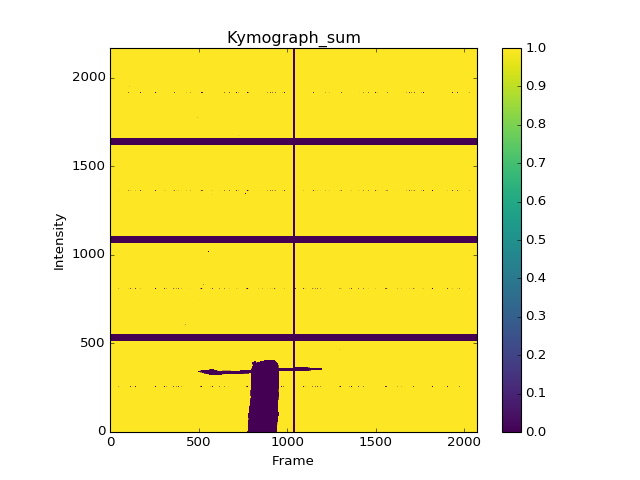

In [18]:
fig, ax = plt.subplots()
im=ax.imshow(maskr, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [19]:
def view_image(i):    
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    

In [20]:
#interact(view_image, i=(0, Nimg-1))

## Movie

In [21]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        im=ax.imshow(imgs[i]*mask,  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.01, vmax=10 ) )
        ax.set_title("images_%s"%i)
        
        time.sleep( sleeps )
        plt.draw()
    #fig.colorbar(im)
        
#view_image(.2, 0, 2)

### hey, let's see if any images are bad!

#### load the image intensity (kymograph) saved in the mask_pipeline

In [22]:
kymo_sum = np.load( path +  str(uid)+"_kymo_sum.npy" ) 

In [23]:
bad_frames = np.where( kymo_sum > 1e5)[0]
bad_frames

array([7629])

<IPython.core.display.Javascript object>


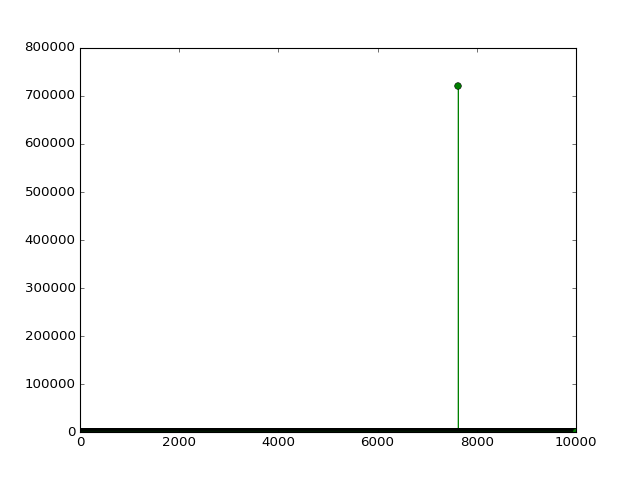

In [24]:
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Get the Averaged Image Data

#### load the average intensity saved in the mask_pipeline

In [25]:
avg_img = np.load( path + str(uid)+"_avg_img.npy" )
avg_imgm =  avg_img * mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software 

In [26]:
avg_imgr  = avg_img[::-1,:] 
avg_imgmr  = avg_imgm[::-1,:] 

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


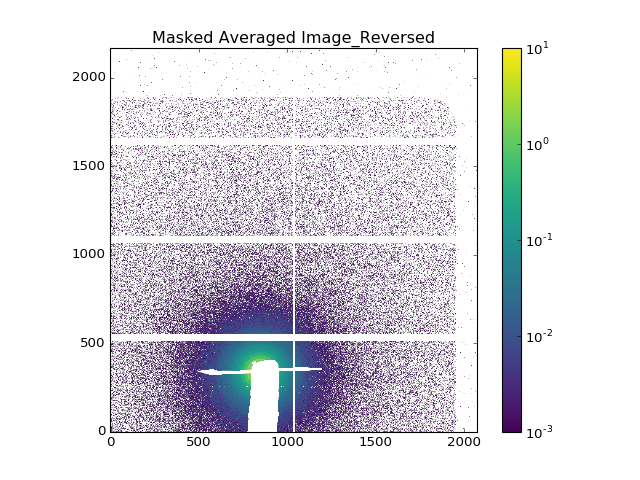

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


## Get the approximate center and see the statistic to make sure 

In [28]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(852.0, 1830.0)

In [29]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [ 2167 - 336, 849]  #for not reversed
center = [ 336, 849]  #for reversed
center = [ 2167- 1830, 846]
 
center

[337, 846]

# check the center with a ring
###to be done-->> a better beam center finding algorithm

<IPython.core.display.Javascript object>


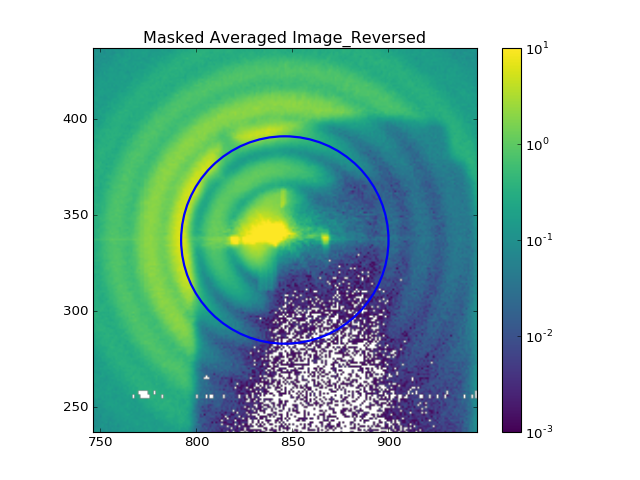

/home/yuzhang/.conda/envs/user_analysis/lib/python3.4/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


In [30]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgr, cmap='viridis',origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1))

radius = 54
circle=plt.Circle( [center[1], center[0]], radius, color='b', alpha=1.0, lw=2, edgecolor='r',fill=False)
plt.gcf().gca().add_artist(circle)


ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)


rwidth = 100 
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
ax.set_xlim( [x1,x2])
ax.set_ylim( [y1,y2])

plt.show()

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [31]:
bin_centers, ring_averages= circular_average(avg_imgr,  center, pixel_size=(dpix, dpix), mask= maskr)

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

<IPython.core.display.Javascript object>


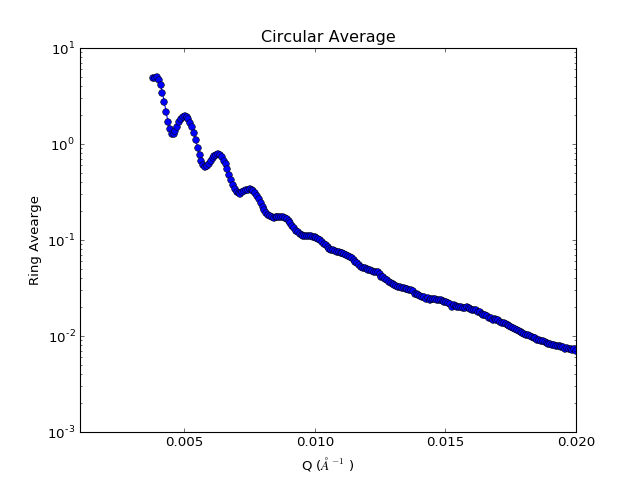

In [32]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Q ('r'$\AA^{-1}$ )')
axes.set_xlim(0.001, 0.02)
axes.set_ylim(0.001, 10.0)
plt.show()

<IPython.core.display.Javascript object>


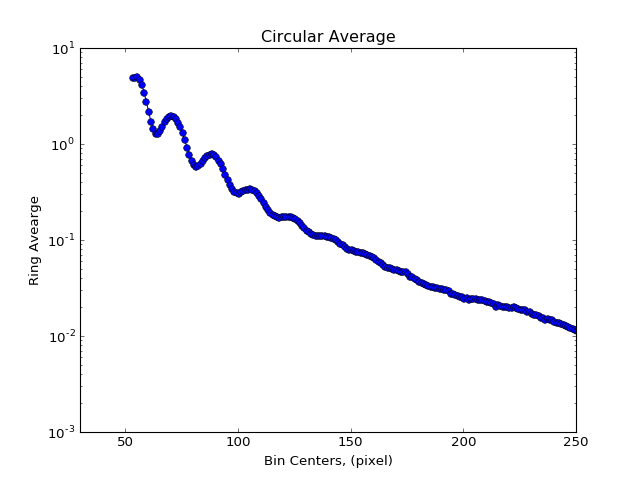

In [33]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(bin_centers/dpix, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers, (pixel)')
axes.set_xlim(30,  250)
axes.set_ylim(0.001, 10.0)
plt.show()

## Create label array (Q rings)

In [34]:
inner_radius = 58 # radius of the first ring
width = 2       # width of each ring
spacing =  (166 - 58)/9 - 2    # spacing between rings
num_rings = 6   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  58.,   60.],
       [  70.,   72.],
       [  82.,   84.],
       [  94.,   96.],
       [ 106.,  108.],
       [ 118.,  120.]])

In [35]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00419415,  0.0050472 ,  0.00590025,  0.00675329,  0.00760634,
        0.00845939])

In [36]:
rings = roi.rings(edges, center, avg_imgmr.shape)

ring_mask = rings*maskr

## Extract the labeled array

In [37]:
ring_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
qind, pixelist = roi.extract_label_indices(   ring_mask  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:]  

In [39]:
qind

array([6, 6, 6, ..., 6, 6, 6])

In [40]:
nopr

array([ 128,  312,  459,  583,  848, 1068])

## Number of pixels in each q ring

# check center

<IPython.core.display.Javascript object>


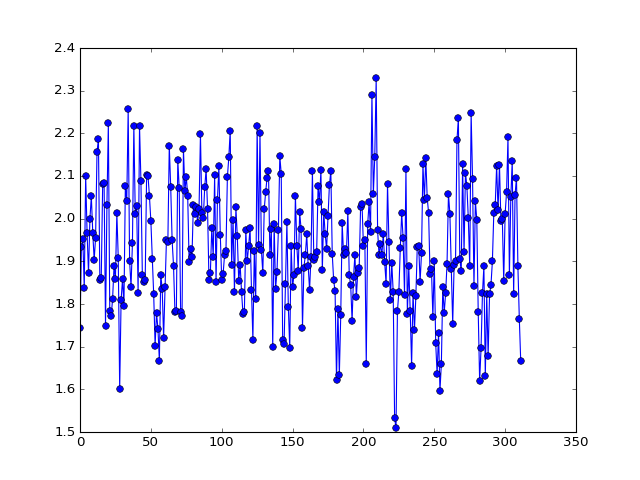

In [41]:
pixel = roi.roi_pixel_values(avg_imgmr, ring_mask, [2] )
fig,ax=plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )


<IPython.core.display.Javascript object>


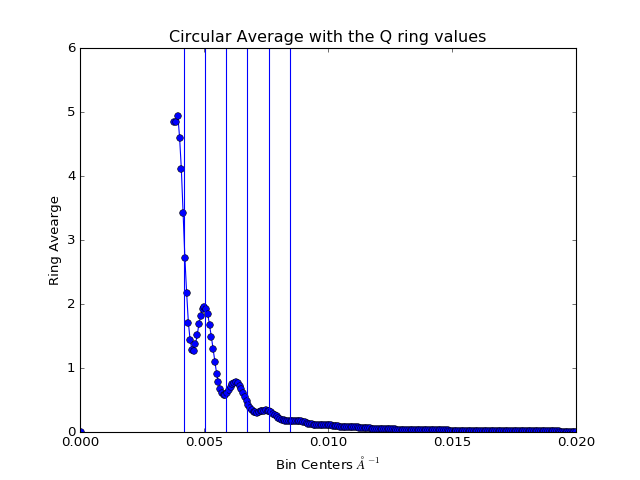

In [42]:
fig, axes = plt.subplots( figsize=(8, 6))
#axes.semilogy(q_val, ring_averages, '-o')
axes.plot(q_val, ring_averages, '-o')
axes.set_title('Circular Average with the Q ring values')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0.00, 0.02)
axes.set_ylim(0, 6)
for i in range(num_rings):
    axes.axvline(q_ring_center[i])
plt.show()

In [42]:
#plt.close('all')

<IPython.core.display.Javascript object>


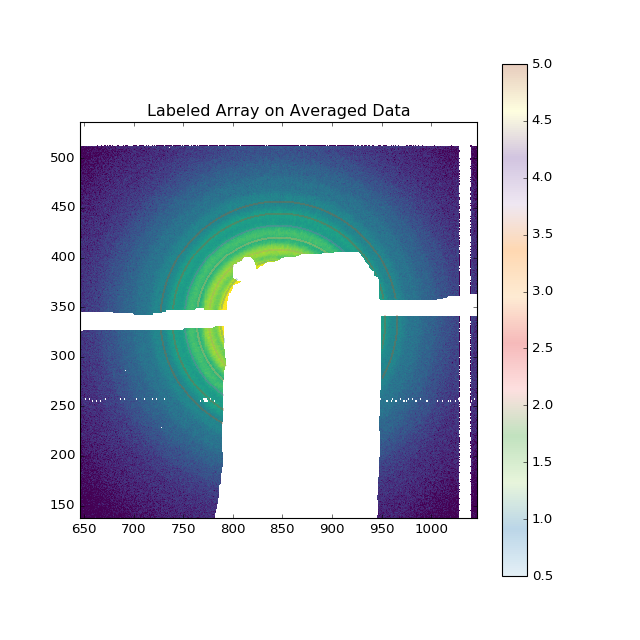

In [44]:

# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im,im_label = show_label_array_on_image(axes, avg_imgmr, ring_mask, imshow_cmap='viridis',
                        cmap='Paired',
                         vmin=0.01, vmax=5,  origin="lower")
#rwidth = 200 
#x1,x2 = [center[1] - rwidth, center[1] + rwidth]
#y1,y2 = [center[0] - rwidth, center[0] + rwidth]
#axes.set_xlim( [x1,x2])
#axes.set_ylim( [y1,y2])

#fig.colorbar(im)
rwidth = 200 

x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])
fig.colorbar(im_label)
plt.show()

##  Kymograph(waterfall plot) of the max-intensity ring

In [45]:
imgs_ =imgs
imgsr = Reverse_Coordinate(imgs_, mask)    

### users put the number of ring with max intensity here

In [49]:
max_inten_ring =2

In [46]:
#kymo = roi.kymograph(imgsr, ring_mask, num = max_inten_ring)

In [46]:
t0 = time.time()

data_pixel =   Get_Pixel_Array( imgsr, pixelist).get_data()
#data_pixel = np.load( path + 'uid_%s_data_pixel.npy'%(uid) )
run_time(t0)

Total time: 0.00 min


In [ ]:
#np.save( path + 'uid_%s_data_pixel'%uid, data_pixel)
#data_pixel = np.load( path + 'uid_%s_data_pixel.npy'%(uid) )

In [50]:
pixelist_qi =  np.where( qind == max_inten_ring)[0]         
data_pixel_qi = data_pixel[:,pixelist_qi] 

<IPython.core.display.Javascript object>


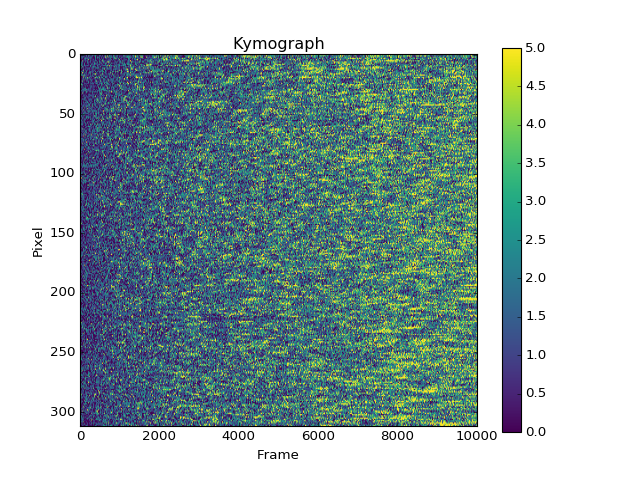

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(data_pixel_qi.T, cmap='viridis', vmax=5.0)
fig.colorbar( im   )
ax.set_aspect(30.)
plt.show()

##  Time~Mean intensities for each ring

In [52]:
mean_inten = get_mean_intensity( data_pixel, qind)

<IPython.core.display.Javascript object>


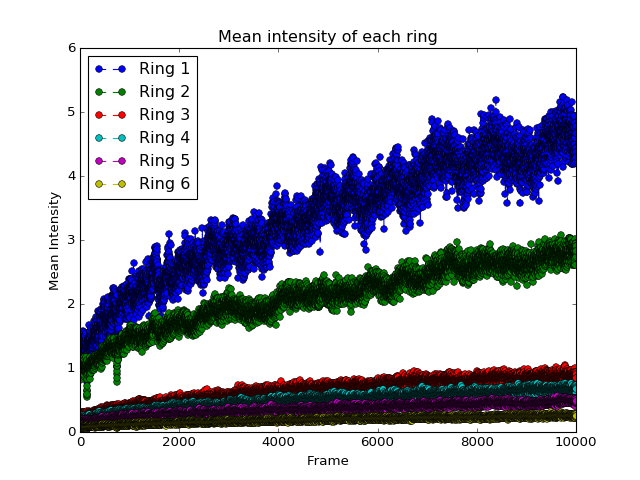

In [53]:
times = np.arange(  mean_inten[1].shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(times, mean_inten[i+1], '--o', label="Ring "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
ax.legend(loc='best') 
plt.show()

##  Mean intensities for each ring

In [54]:
K_mean = np.array( [mean_inten[i].mean() for i in  list(mean_inten.keys() )] )

In [55]:
K_mean

array([ 3.36094063,  2.10911154,  0.65901917,  0.49677616,  0.3595105 ,
        0.18890328])

## XSVS analysis

#### Get max count number

In [56]:
max_cts = data_pixel.max()
max_cts

26.0

### Users provide frame info (start-frame and end-frame) for analysis

In [57]:
good_start = 0
good_end =  10# if using Nimg, then calculate all the images

good_end =    Nimg  #hen calculate all the images
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask) 

In [58]:
len(imgs_)

10000

In [59]:
time_steps = utils.geometric_series(2,   len(imgs_)   ) [:-3]
time_steps

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [62]:
#time_steps = utils.geometric_series(2,   600  )
#time_steps

In [60]:
num_times = len(time_steps)

In [64]:
spe_cts_all, std_dev = xsvs( (imgsr,), np.int_(ring_mask), timebin_num=2,
        number_of_img= len(imgs_), max_cts=int(max_cts+2), bad_images=None, threshold = 5000 )

##########Total time: 4.44 min


In [61]:
#np.save( path + 'uid_%s_spe_cts_all'%uid, spe_cts_all)
#spe_cts_all = np.load(path + 'uid_%s_spe_cts_all.npy'%uid )
 

### This will provide the normalized bin edges for each integration time

In [ ]:
#Knorm_bin_edges, Knorm_bin_centers = speckle.normalize_bin_edges( len(time_steps), num_rings, K_mean, int(max_cts+2))

In [62]:
bin_edges, bin_centers, Knorm_bin_edges, Knorm_bin_centers = get_bin_edges(
      len(time_steps), num_rings, K_mean, int(max_cts+2)  )

### Plot the results for each q ring

<IPython.core.display.Javascript object>


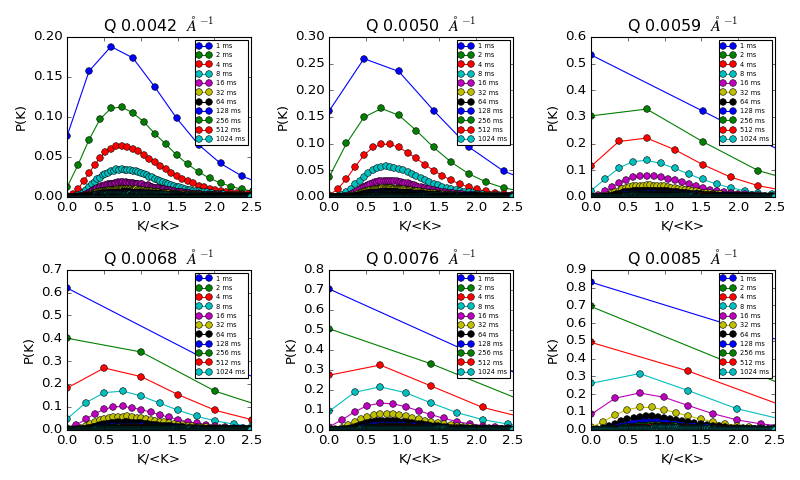

In [63]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(10,6))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    for j in range(len(time_steps)):
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], '-o',
                     label=str(time_steps[j])+" ms")
        axes.set_xlim(0, 2.5)
        axes.set_title("Q "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 6)
plt.show()
fig.tight_layout() 

### Plot the results with error bars

In [64]:
if False:
    
    sx = int(round(np.sqrt(num_rings)) )
    if num_rings%sx == 0: 
        sy = int(num_rings/sx)
    else:
        sy=int(num_rings/sx+1)
    fig = plt.figure(figsize=(10, 6))
    plt.title('uid= %s'%uid,fontsize=20, y =1.02)  
    plt.axes(frameon=False)
    plt.xticks([])
    plt.yticks([])
    for i in range(num_rings):
        for j in range(len(time_steps)):
            axes = fig.add_subplot(sx, sy, i+1 )
            axes.set_xlabel("K/<K>")
            axes.set_ylabel("P(K)")
            art = axes.errorbar(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i],
                         std_dev[j, i], fmt='-o',label=str(time_steps[j])+" ms")

            axes.set_xlim(0, 2.5)
            axes.set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
            axes.legend(loc='best', fontsize = 6)
    plt.show()
    fig.tight_layout() 




## Fit XSVS results

## Negative Binomaial Distribution
$P(K) =(\frac{M}{<K>})^M \frac{K ^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})$
             

## Gamma Distribution

$P(K)=\frac{\Gamma(K+M)}{\Gamma(K+1)\Gamma(M)}(\frac{M}{M+<K>})^M(\frac{<K>}{M+<K>})^K$

## Poission Distribution
$P(K) = \frac{<K>^K}{K!}\exp(-<K>)$

### Fitting with Negative Binomial and Gamma and Poisson Distribution

In [65]:
from lmfit import  Model
from scipy.interpolate import UnivariateSpline

g_mod = Model(gamma_dist, indepdent_vars=['K'])
#g_mod = Model( gamma_dist )
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)
dc_mod = Model(diff_mot_con_factor)

In [66]:
#gamma_dist??

## fit with Negative Binomial Function

<IPython.core.display.Javascript object>


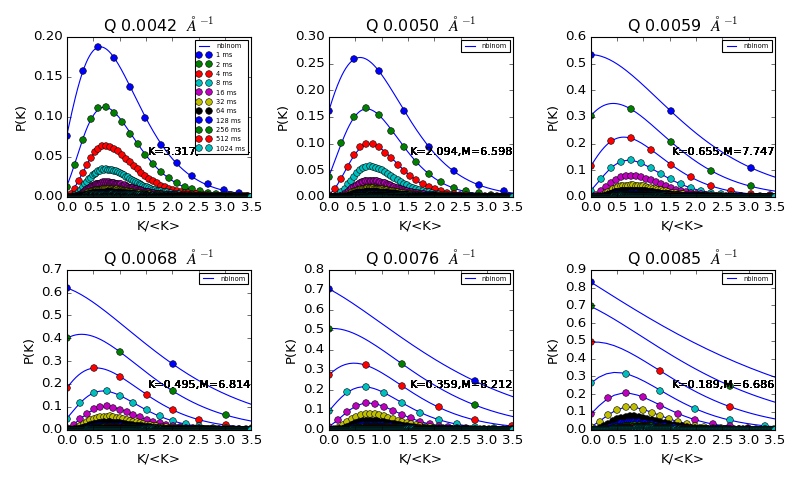

In [67]:
M_val = {}
K_val = {}
sx = int(round(np.sqrt(num_rings)))
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(10, 6))
plt.title('uid= %s'%uid+" Fitting with Negative Binomial Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    M_val[i]=[]
    K_val[i]=[]
    for j in range(   num_times  ):
        # find the best values for K and M from fitting
        result_n = n_mod.fit(spe_cts_all[j, i],
                             bin_values=bin_edges[j, i][:-1],
                             K=5 * 2**j, M=12)
        M_val[i].append(result_n.best_values['M'])
        K_val[i].append(result_n.best_values['K'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best K and M values interpolate and get more values for fitting curve
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 1000     )   
        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 1000  )         
        fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-b',  label="nbinom")
        else:
            art, = axes.plot( fitx_,fity, '-b')
        
                    
        if i==0:    
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        else:
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     )

        
        axes.set_xlim(0, 3.5)
        # Annotate the best K and M values on the plot
        axes.annotate(r'K='+'%.3f'%( K_val[i][0]) +','+r'M='+'%.3f'%(M_val[i][0]),
                      xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=10,
                      horizontalalignment='right', verticalalignment='bottom')
        axes.set_title("Q "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 6)
plt.show()
fig.tight_layout()  

In [69]:
[K_val[i][0] for i in range(num_rings)]

[3.3165319464701533,
 2.0941134953236222,
 0.65487867458291715,
 0.49482226403256657,
 0.35853928147592601,
 0.18873607742325987]

In [70]:
#[K_val[i][3] for i in range(num_rings)]

In [71]:
K_mean

array([ 3.36094063,  2.10911154,  0.65901917,  0.49677616,  0.3595105 ,
        0.18890328])

## This will provide the better range to fit

In [72]:
def get_roi(data, threshold=1e-3):
    roi = np.where(data>threshold)
    if len(roi[0]) > len(data)-2:
        roi = (np.array(roi[0][:-2]),)                    
    elif len(roi[0]) < 2:
        roi = np.where(data>=0)
    return roi[0]
        
    

In [73]:
roi = get_roi(data=spe_cts_all[j, i], threshold=1e-3)

### Fit with Gamma Distribution

<IPython.core.display.Javascript object>


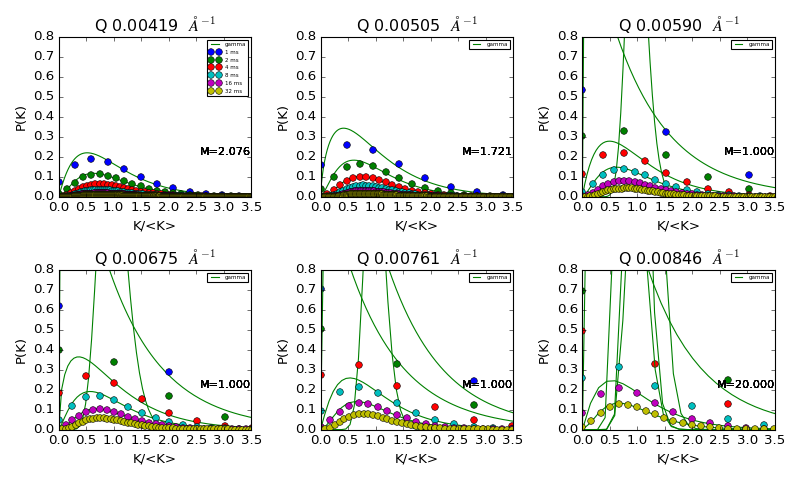

In [74]:

Mg_val = {}
fig = plt.figure(figsize=(10, 6))
plt.title('uid= %s'%uid+ " Fitting with Gamma Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

for i in range(num_rings):
    Mg_val[i] = []
    for j in range( 0, 6  ):        
        roi = get_roi(data=spe_cts_all[j, i], threshold=1e-7)  
        
        # find the best value for M from fitting     
        result_g = g_mod.fit(spe_cts_all[j, i][roi] ,
                             bin_values=bin_edges[j, i][:-1][roi] ,
                             K=K_mean[i]*2**j,  M= 20 )
        
        
        Mg_val[i].append(result_g.best_values['M'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best M value interpolate and get more values for fitting curve
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 1000   )
        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 1000   )         
        fity = gamma_dist( fitx, K_mean[i]*2**j,  Mg_val[i][j] )

        
        if j == 0:
            art, = axes.plot( fitx_,fity, '-g',label="gamma") 
        else:
            art, = axes.plot( fitx_,fity, '-g' ) 
            
        if i==0:    
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        else:
            art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     )
                                  
        
        axes.set_xlim(0, 3.5)
        axes.set_ylim(0, .8)
        # Annotate the best M values on the plot 
        axes.annotate(r'M='+'%.3f'%(Mg_val[i][0]), xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=10,
                      horizontalalignment='right', verticalalignment='bottom')
        axes.set_title("Q "+ '%.5f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 5)
fig.tight_layout()         
plt.show()
 

## Fit with Poisson Distribution

<IPython.core.display.Javascript object>


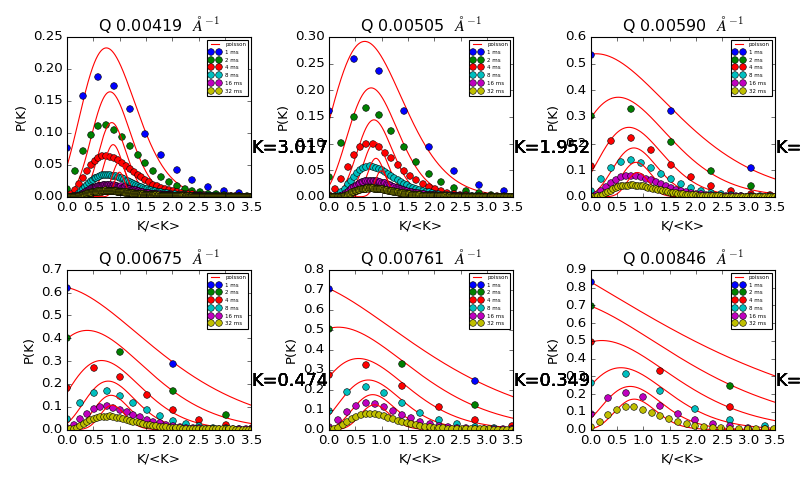

In [85]:
Kp_val = {}
sx = int(round(np.sqrt(num_rings)))
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(10,6))
plt.title('uid= %s'%uid+" Fitting with Poission Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])


for i in range(num_rings):
    Kp_val[i] = []
    for j in range(  6 ):
        roi = get_roi(data=spe_cts_all[j, i], threshold=1e-8)   
        
        # find the best value for K from fitting  
        result_p = p_mod.fit(spe_cts_all[j, i][roi],
                             bin_values=bin_edges[j, i][:-1][roi],
                             K=K_mean[i]*2**j)  
        
        Kp_val[i].append(result_p.best_values['K'])
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        
        #  Using the best K value interpolate and get more values for fitting curve
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000 )  # these x values to plot      
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000 )     # these x values for interpolation    
        fity = poisson_dist(fitx, Kp_val[i][j]  ) 
        
        if j == 0:
            art, = axes.plot(fitx_, fity, '-r', label="poisson")
        else:
            art, = axes.plot(fitx_, fity, '-r') 
            
 
        art, = axes.plot( Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], 'o',
                     label=str(time_steps[j])+" ms")
        axes.set_xlim(0, 3.5)           
        # Annotate the best K values on the plot    
        axes.annotate(r'K='+'%.3f'%(Kp_val[i][0]), xy=(1, 0.25),
                      xycoords='axes fraction', fontsize=16,
                      horizontalalignment='best', verticalalignment='best')
        
        axes.set_title("Q "+ '%.5f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend(loc='best', fontsize = 5)
plt.show()
fig.tight_layout()  

## Get the contast factor of detected signals is 1/M

$ \beta = 1/M $

In [86]:
contrast_factor = np.zeros((num_rings, num_times))

for i in range(num_rings):
    for j in range(num_times):
        contrast_factor[i, j] =  1/M_val[i][j]
#contrast_factor 

In [87]:
contrast_factor[0, :]

array([ 0.20145751,  0.19958302,  0.19866969,  0.19844628,  0.19822649,
        0.19642433,  0.19127878,  0.17949567,  0.16201641,  0.13768049,
        0.12513516])

In [88]:
times = np.array( time_steps ) * exposuretime

<IPython.core.display.Javascript object>


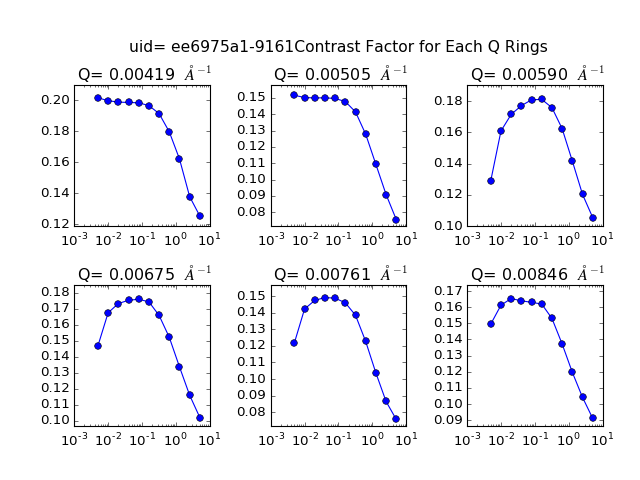

In [98]:
 
sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "Contrast Factor for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-o", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
              
 
fig.tight_layout() 

### get fit of contrast factor

<IPython.core.display.Javascript object>


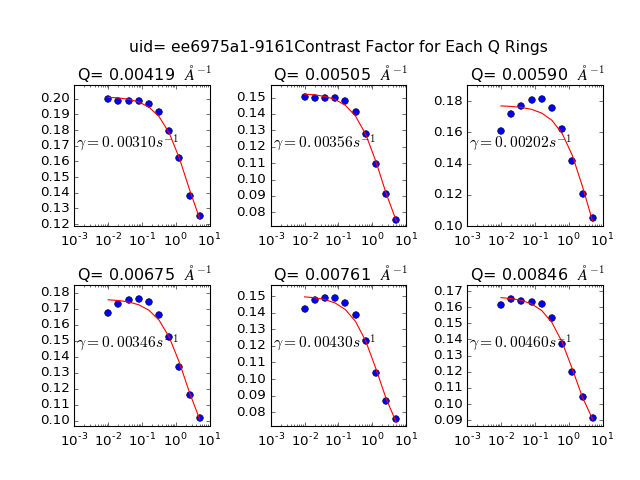

In [99]:
relax_rate = []

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "Contrast Factor for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 )
    
    time_steps_ = time_steps[1:]
    times_ = times[1:]
    y= contrast_factor[sn, 1:]  
    result_dc = dc_mod.fit(y, times=time_steps_,
                           relaxation_rate=1.0, contrast_factor=0.78, cf_baseline=0)
    relax_rate.append(result_dc.best_values['relaxation_rate'])
 
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times_, y, "o", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times_, result_dc.best_fit, '-r')
 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.5f$'%(relax_rate[sn]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
 
fig.tight_layout() 

In [91]:
relax_rate

[0.00309691088264163,
 0.003560595049828925,
 0.0020230945390244757,
 0.0034639859173625806,
 0.0043029580241171067,
 0.0046028781949586295]

<IPython.core.display.Javascript object>


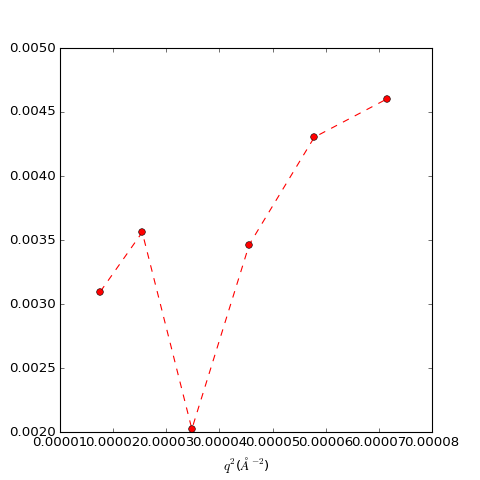

In [100]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(q_ring_center**2, relax_rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

In [93]:
D0 = np.polyfit(q_ring_center**2, relax_rate, 1)
gmfit = np.poly1d(D0)
print ('The fitted diffusion coefficient D0 is:  %.2E'%D0[0]  +  r'$\AA^{-2}$')

The fitted diffusion coefficient D0 is:  3.14E+01$\AA^{-2}$


<IPython.core.display.Javascript object>


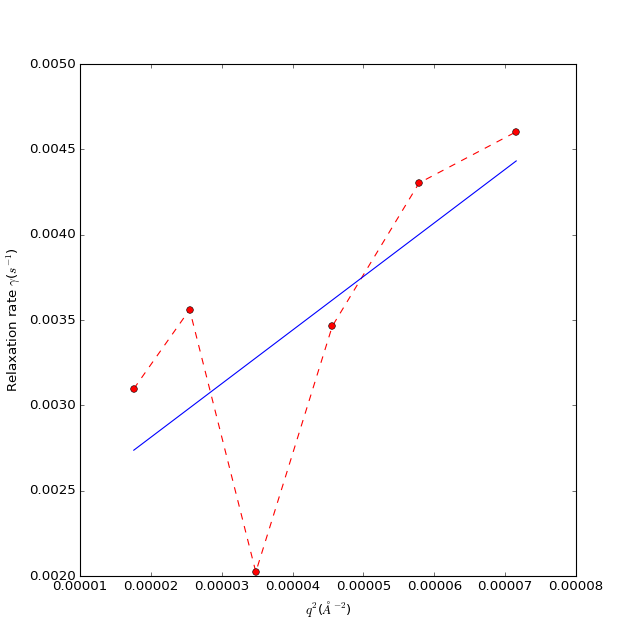

In [101]:
fig, ax = plt.subplots(figsize=(8, 8) )
ax.plot(q_ring_center**2, relax_rate, 'ro', ls='--')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## A comparision with xpcs results

In [95]:
tg2 = np.loadtxt(  path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end))
lags, g2 = tg2[:,0], tg2[:,1:]

<IPython.core.display.Javascript object>


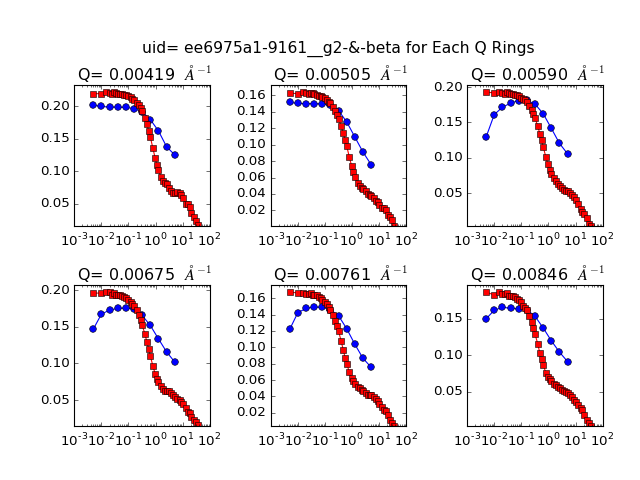

In [102]:
sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
#fig = plt.figure(figsize=(14, 10))
fig = plt.figure()
plt.title('uid= %s'%uid + "__g2-&-beta for Each Q Rings", fontsize=14, y =1.08)  
plt.axis('off')
for sn in range(num_rings):
    ax = fig.add_subplot(sx, sy, sn+1 ) 
    y= contrast_factor[sn, :]   
    #ax.plot(contrast_factor[i, :], "o", label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.semilogx(times, y, "-bo", 
                label="Q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$') 
    
    y2=g2[:, sn]
    ax.semilogx(lags, y2 -1 , '-rs', markersize=6) 
    
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[sn]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y2-1)*.95, max(y2[1:]-1) *1.05])
              
 
fig.tight_layout() 

# The end!